In [16]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from utils.dataio import *
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/'

### Load data

In [17]:
config = load_config('../config.yaml')
n_samples = 5

In [18]:
ip_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
ip_gt = standardize(ip_gt)
data_range_ip = ip_gt.max() - ip_gt.min()

### Number of delays 

In [19]:
n_delays_list = [64,32,16,8,4,2,1]
n_delays_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, n_delays in enumerate(n_delays_list):
        params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(n_delays, 1, 64, 1e-4, 10, 64, 1e-3)
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

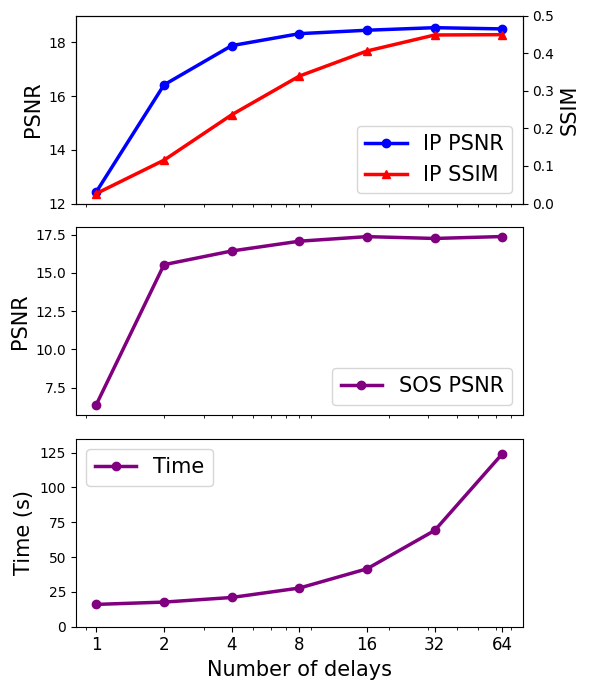

In [20]:
fig = plt.figure(figsize=(6,7))
ax1 = plt.subplot(3,1,1)
ax2 = ax1.twinx()
line_psnr = ax1.plot(n_delays_list, ip_psnrs.mean(0), label='IP PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(n_delays_list, ip_ssims.mean(0), label='IP SSIM', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([12, 19])
ax2.set_ylim([0.0, 0.5])
ax1.set_xscale('log')
ax1.set_xticks([])
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15)

ax = plt.subplot(3,1,2)
ax.plot(n_delays_list, sos_psnrs.mean(0), label='SOS PSNR', marker='o', color='purple', linewidth=2.5)
ax.set_ylim([5.7, 18])
ax.set_xscale('log')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xticks([])
ax.legend(fontsize=15)

ax = plt.subplot(3,1,3)
ax.plot(n_delays_list, times.mean(0), label='Time', marker='o', color='purple', linewidth=2.5)
ax.set_ylim([0, 135])
ax.set_xscale('log')
ax.set_ylabel('Time (s)', fontsize=15)
ax.set_xticks([1,2,4,8,16,32,64], ['1','2','4','8','16','32','64'], fontsize=12)
ax.set_xlabel('Number of delays', fontsize=15)
ax.legend(fontsize=15)

plt.tight_layout()
plt.savefig('ablation_n_delays.png', bbox_inches='tight', dpi=256)

### TV Regularization weight

In [21]:
lam_tv_list = [1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3]
lam_tv_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(lam_tv_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, lam_tv in enumerate(lam_tv_list):
        if lam_tv == 0:
            params = '{}delays_{}lyrs_{}fts_{}epochs_bs={}_lr={:.1e}'.format(32, 1, 64, 15, 64, 1e-3)
        else:
            params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(32, 1, 64, lam_tv, 15, 64, 1e-3)
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

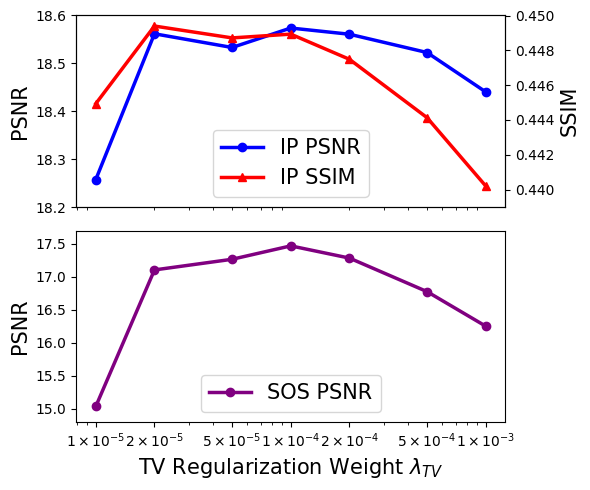

In [22]:
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(2,1,1)
ax2 = ax1.twinx()
line_psnr = ax1.plot(lam_tv_list, ip_psnrs.mean(0), label='IP PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(lam_tv_list, ip_ssims.mean(0), label='IP SSIM', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([18.2, 18.6])
ax2.set_ylim([0.439, 0.450])
ax1.set_xscale('log')
ax1.set_xticks([])
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc='lower center')

ax = plt.subplot(2,1,2)
ax.plot(lam_tv_list, sos_psnrs.mean(0), label='SOS PSNR', marker='o', color='purple', linewidth=2.5)
ax.set_ylim([14.8, 17.7])
ax.set_xscale('log')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xticks([1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3], 
              [r'$1\times10^{-5}$', r'$2\times10^{-5}$', r'$5\times10^{-5}$', r'$1\times10^{-4}$', r'$2\times10^{-4}$', r'$5\times10^{-4}$', r'$1\times10^{-3}$'],
              fontsize=10)
ax.set_xlabel('TV Regularization Weight $\lambda_{TV}$', fontsize=15)
ax.legend(fontsize=15, loc='lower center')

plt.tight_layout()
plt.savefig('ablation_lam_tv.png', bbox_inches='tight', dpi=256)

### Network structure

In [23]:
hidden_fts_list = [16,32,64,128,256]
hidden_fts_list.sort()
hidden_lyrs_list = [1,2]
hidden_lyrs_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times, n_params = [np.zeros((n_samples, len(hidden_lyrs_list), len(hidden_fts_list))) for _ in range(6)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    data_range_sos = sos_gt.max() - sos_gt.min()
    for i, hidden_lyrs in enumerate(hidden_lyrs_list):
        for j, hidden_fts in enumerate(hidden_fts_list):
            params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(32, hidden_lyrs, hidden_fts, 1e-4, 10, 64, 1e-3)
            results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
            ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
            sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
            ip_rec = standardize(ip_rec)
            log = load_log(os.path.join(results_path, 'log.json'))
            ip_psnrs[sample_id, i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
            ip_ssims[sample_id, i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
            sos_psnrs[sample_id, i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
            sos_ssims[sample_id, i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
            times[sample_id, i, j] = log['time']
            n_params[sample_id, i, j] = log['n_params']

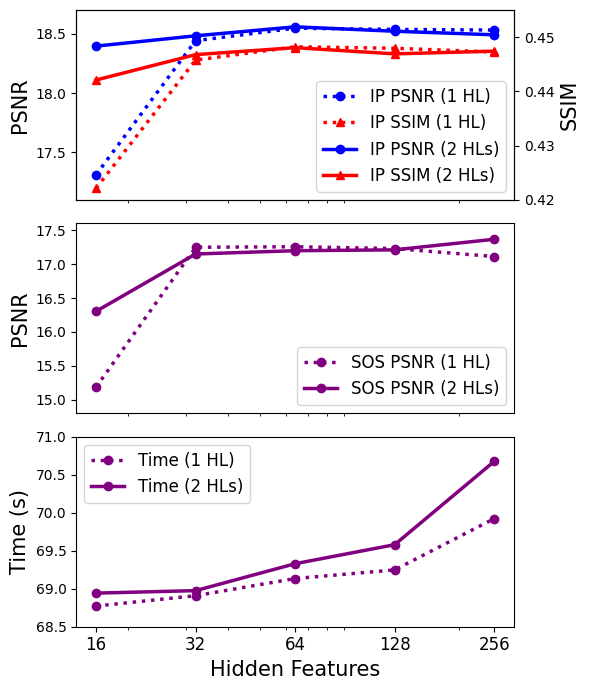

In [24]:
fig = plt.figure(figsize=(6,7))
ax1 = plt.subplot(3,1,1)
ax2 = ax1.twinx()
line_psnr1 = ax1.plot(hidden_fts_list, ip_psnrs[:,0,:].mean(0), label='IP PSNR (1 HL)', linestyle=':', marker='o', color='blue', linewidth=2.5)
line_ssim1 = ax2.plot(hidden_fts_list, ip_ssims[:,0,:].mean(0), label='IP SSIM (1 HL)', linestyle=':', marker='^', color='red', linewidth=2.5)
line_psnr2 = ax1.plot(hidden_fts_list, ip_psnrs[:,1,:].mean(0), label='IP PSNR (2 HLs)', marker='o', color='blue', linewidth=2.5)
line_ssim2 = ax2.plot(hidden_fts_list, ip_ssims[:,1,:].mean(0), label='IP SSIM (2 HLs)', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([17.1, 18.7])
ax2.set_ylim([0.42, 0.455])
ax1.set_xscale('log')
ax1.set_xticks([])
ax2.set_xscale('log')
ax2.set_xticks([])
lns1 = line_psnr1 + line_ssim1 + line_psnr2 + line_ssim2
labels1 = [l.get_label() for l in lns1]
ax1.legend(lns1, labels1, fontsize=12, loc='lower right')
# lns2 = line_psnr2 + line_ssim2
# labels2 = [l.get_label() for l in lns2]
# ax2.legend(lns2, labels2, fontsize=9.7, loc='lower right')

ax = plt.subplot(3,1,2)
ax.plot(hidden_fts_list, sos_psnrs[:,0,:].mean(0), label='SOS PSNR (1 HL)', linestyle=':', marker='o', color='purple', linewidth=2.5)
ax.plot(hidden_fts_list, sos_psnrs[:,1,:].mean(0), label='SOS PSNR (2 HLs)', marker='o', color='purple', linewidth=2.5)
ax.set_ylim([14.8, 17.6])
ax.set_xscale('log')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xticks([])
ax.legend(fontsize=12, loc='lower right')

ax = plt.subplot(3,1,3)
ax.plot(hidden_fts_list, times[:,0,:].mean(0), label='Time (1 HL)', linestyle=':', marker='o', color='purple', linewidth=2.5)
ax.plot(hidden_fts_list, times[:,1,:].mean(0), label='Time (2 HLs)', marker='o', color='purple', linewidth=2.5)
ax.set_ylim([68.5, 71])
ax.set_xscale('log')
ax.set_ylabel('Time (s)', fontsize=15)
ax.set_xticks([16,32,64,128,256], ['16','32','64','128','256'], fontsize=12)
ax.set_xlabel('Hidden Features', fontsize=15)
ax.legend(fontsize=12, loc='upper left')

plt.tight_layout()
plt.savefig('ablation_network.png', bbox_inches='tight', dpi=256)